In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd

np.random.seed(23) 

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df = pd.DataFrame(class1_sample,columns=['feature1','feature2','feature3'])
df['target'] = 1

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df1 = pd.DataFrame(class2_sample,columns=['feature1','feature2','feature3'])

df1['target'] = 0

df = pd.concat([df, df1], ignore_index=True)

df = df.sample(40)

In [4]:
df.head()

,feature1,feature2,feature3,target
2,-0.367548,-1.137460,-1.322148,1
34,0.177061,-0.598109,1.226512,0
14,0.420623,0.411620,-0.071324,1
11,1.968435,-0.547788,-0.679418,1
12,-2.506230,0.146960,0.606195,1


In [5]:
import plotly.express as px
#y_train_trf = y_train.astype(str)
fig = px.scatter_3d(df, x=df['feature1'], y=df['feature2'], z=df['feature3'],
              color=df['target'].astype('str'))
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

In [6]:
# Step 1 - Apply standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:3] = scaler.fit_transform(df.iloc[:,0:3])

In [7]:
# Step 2 - Find Covariance Matrix
covariance_matrix = np.cov([df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]])
print('Covariance Matrix:\n', covariance_matrix)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


In [8]:
# Step 3 - Finding EV and EVs
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [9]:
eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

In [10]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

Populating the interactive namespace from numpy and matplotlib


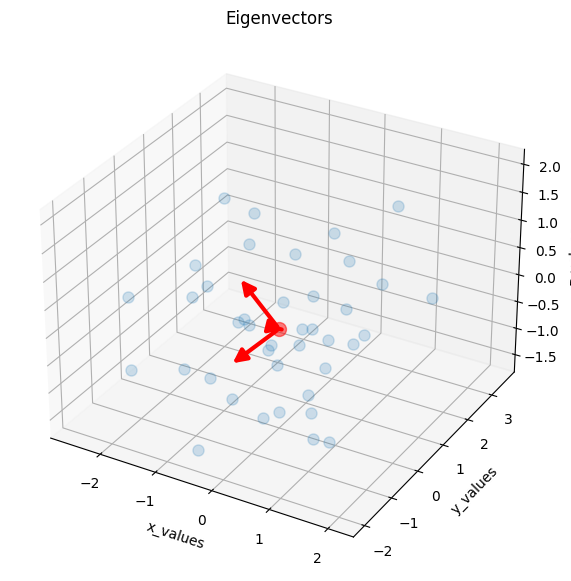

In [12]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(
            xs3d, ys3d, zs3d, self.axes.get_proj()
        )
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

    def draw(self, renderer):
        self.do_3d_projection(renderer)
        super().draw(renderer)


# Create 3D Plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
ax.plot(
    df['feature1'], 
    df['feature2'], 
    df['feature3'], 
    'o', markersize=8, alpha=0.2
)

# Plot mean point
ax.plot(
    [df['feature1'].mean()],
    [df['feature2'].mean()],
    [df['feature3'].mean()],
    'o', markersize=10, color='red', alpha=0.5
)

# Plot eigenvectors as arrows
for v in eigen_vectors.T:
    a = Arrow3D(
        [df['feature1'].mean(), v[0]],
        [df['feature2'].mean(), v[1]],
        [df['feature3'].mean(), v[2]],
        mutation_scale=20,
        lw=3,
        arrowstyle="-|>",
        color="r"
    )
    ax.add_artist(a)

# Labels
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')
plt.show()


In [13]:
pc = eigen_vectors[0:2]
pc

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442]])

In [14]:
transformed_df = np.dot(df.iloc[:,0:3],pc.T)
# 40,3 - 3,2
new_df = pd.DataFrame(transformed_df,columns=['PC1','PC2'])
new_df['target'] = df['target'].values
new_df.head()

,PC1,PC2,target
0,0.599433,1.795862,1
1,1.056919,-0.212737,0
2,-0.271876,0.498222,1
3,-0.621586,0.023110,1
4,1.567286,1.730967,1


In [15]:
new_df['target'] = new_df['target'].astype('str')
fig = px.scatter(x=new_df['PC1'],
                 y=new_df['PC2'],
                 color=new_df['target'],
                 color_discrete_sequence=px.colors.qualitative.G10
                )

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()